In [37]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

In [38]:
sales = pd.read_csv("/content/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

In [39]:
sales.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


### **Exploratory Data Analysis (EDA)**

In [40]:
#Check to ensure we are seeing all columns
sales.columns

Index(['order_id', 'shop_id', 'user_id', 'order_amount', 'total_items',
       'payment_method', 'created_at'],
      dtype='object')

In [41]:
#Check to ensure the size of dataset
sales.shape

(5000, 7)

In [42]:
#Check data types
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [43]:
#Viewing descriptive statistics of two columns
sales[['order_amount', 'total_items']].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


In [44]:
#Check if data has nulls
null_check = sales.isnull().sum().to_frame()
null_check.columns = ['number_null']
null_check

,number_null
order_id,0
shop_id,0
user_id,0
order_amount,0
total_items,0
payment_method,0
created_at,0


## **Solution 1**

The reason of the analysis seems wrong because the analysis is done with the wrong data and wrong metrics. There are certain skewness in the dataset. 
- Average calculated is based on the order_amount and number of orders instead of order_amount and total_items sold. 
  - Solution: Scale total_items to 1 items and engineer a new feature. 
- Remove anomolies and re-evaluate the average price value: 
  - For instance, we see 17 instances of 2000 items purchased, which of
course will skew the average; we should take out shop 42.
  - As well, the average order will also be skewed because shop 78 is selling
each shoe for about \$27,725; sneakers should not be this high!
  - Therefore after taking out the anomalous shops, shop 42 and 78, we get an average order value of \$300, which makes sense as some customers purchase more than 1 item during their visit!

  - We also see that the average number of items purchased (after removing outliers) is about 2 items; this seems correct!

- Use new metrics:
  - Assuming we leave the anomalies in for data reasons, we can use a new
metric to track shoe affordability. As seen previously, the average is \$3145.13 because of anomalies.
  - Hence, we can use the describe() function to assist us with a new metric.
  - After seeing the metrics, we can also implement z-score to see how each transaction differs from the norm. Then, we can filter out anomalies and see what went wrong with our analysis!

In [45]:
#Filter necessary columns for analysis
sales_s1 = sales.copy()
sales_s1 = sales_s1[['shop_id', 'order_amount', 'total_items']]

In [46]:
#Scale purchases to give even weight to total_items
sales_s1['orders_to_one'] = sales_s1['order_amount'] / sales_s1['total_items']

Now we have a column that represents order amount spent, if each customer only bought one item.

In [47]:
sales_s1.head()

,shop_id,order_amount,total_items,orders_to_one
0,53,224,2,112.0
1,92,90,1,90.0
2,44,144,1,144.0
3,18,156,1,156.0
4,18,156,1,156.0


We can now compute average order value for the dataset.

In [48]:
np.mean(sales_s1['orders_to_one'])

387.7428

Why is the average still very high? Let's observe the how much each shop is selling the shoe, and see if someone is overpicing or underpricing

In [49]:
sales_s1.groupby(sales_s1['shop_id'])['orders_to_one'].mean().reset_index().sort_values(by=['orders_to_one'], ascending = False).head()

,shop_id,orders_to_one
77,78,25725.0
41,42,352.0
11,12,201.0
88,89,196.0
98,99,195.0


Therefore, we reveal that shop 78 is overpricing, as to why the average is still high.

In [50]:
#Average after removing shop 78 from calculation
np.mean(sales_s1[sales_s1['shop_id'] != 78]['orders_to_one'])

152.47557529269278

**To conclude, it looks like our shoe is affordable, at an average of $152.48 per shoe across 99 stores**

## **Solution 2: Remove anomalies and re-evaluate average order value**

- Following up with observation 3, it is often incorrect to judge and analyze the dataset based off
of the average. For instance, any majorly large number will skew the average. Hence, we can use percentiles (25%, median, 75%) to judge the entire dataset.
- Adding on to our .describe() function, instead of looking at affordability through the average
order amount of the total dataset, we can look at the z-score of each order, to determine if they are within the limits of a typical order. The z-score tells us the number of standard deviations away from the average, in which this feature would capture irregular values (being outside of
multiple standard deviations).
- Therefore, we now have a metric based off of the entire dataset and a metric to analyze each independent order!


In [51]:
sales_s2 = sales.copy()

Visualize order_amount using histogram

Text(0, 0.5, 'Count')

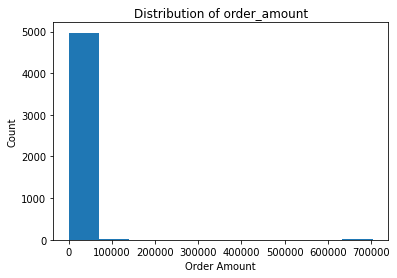

In [52]:
plt.hist(sales_s2['order_amount'])
plt.title('Distribution of order_amount')
plt.xlabel('Order Amount')
plt.ylabel('Count')

We have already seen above that shop 78 is the issue, so we can filter shop 78 at the end.

See number of orders at each amount of total items

In [53]:
sales_s2['total_items'].value_counts()

2       1832
1       1830
3        941
4        293
5         77
2000      17
6          9
8          1
Name: total_items, dtype: int64

**Which store is selling 2000 items per order?**

In [54]:
sales_s2[sales_s2['total_items'] == 2000]['shop_id'].unique()

array([42])

**Is this the shop 42's issue or is it a customer that is driving high order amounts?**

In [55]:
sales_s2 = sales_s2[['shop_id', 'user_id', 'order_amount', 'total_items']]

In [56]:
sales_s2[sales_s2['shop_id'] == 42].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
40,42,793,352,1
60,42,607,704000,2000
308,42,770,352,1
409,42,904,704,2


In [57]:
sales_s2[sales_s2['user_id'] == 607].head()

,shop_id,user_id,order_amount,total_items
15,42,607,704000,2000
60,42,607,704000,2000
520,42,607,704000,2000
1104,42,607,704000,2000
1362,42,607,704000,2000


The reason we remove shop 42 although the anomalies are caused by customer 607 is because as a business, we cannot control how the consumer spends. We can only change how the business acts, removing this customer to strengthen our model for a better understanding of the problem.

In [58]:
filtered_dataset = sales[(sales['shop_id'] != 42) & (sales['shop_id'] != 78)]

In [59]:
# Average amount per order
np.mean(filtered_dataset['order_amount'])

300.1558229655313

In [60]:
# Average items per order
np.mean(filtered_dataset['total_items'])

1.9957169080155006

**To conclude, the average order amount is roughly $300.16, considering that some consumers purchase more than 1 order per visit. This is not an indicator of shoe affordability.**

## **Solution 3: Use new metrics**

- The value of using median is that we disregard anomalies, contrary to using average. Even so, we were able to get 25%, median, and 75% using the describe() function. We actually found
that the 75% percentile is similar to our average. Hence, median (and percentiles) are now a
better judgement of the entire dataset.
- In addition, rather than looking at the whole dataset, we can now see each individual transaction
and analyze whether it is a valid measure of affordability using z-score. - After feature
engineering the standard deviation of each transaction, we can analyze when orders are
anomalous, whether it be from shop 78 that is overpricing the product, or shop 42 that is selling
2000 items per transaction. Knowing that Shopify works with various businesses, we have
pointed out that shop 78 and shop 42 were the reasons why our average order value is skewed,
in which there is value to using z-score.
- To summarize, one investigation turned into two metrics, using percentiles for judgement of the
entire dataset, and z-score as a judgement for each independent order.

In [61]:
sales_s3 = sales.copy()

In [62]:
sales_s3['order_amount'].describe().to_frame().round(2)

,order_amount
count,5000.00
mean,3145.13
std,41282.54
min,90.00
25%,163.00
50%,284.00
75%,390.00
max,704000.00


Quick observations
- Mean is what we expected
- Standard deviation is very high, which indicates large differences in order amount
- 75% percentile represents accurately; it makes sense because some consumers purchase more than one item

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


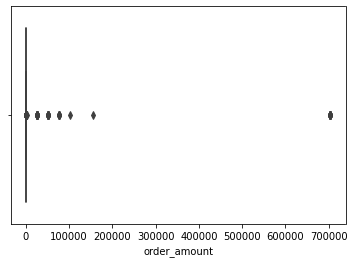

In [63]:
sns.boxplot(sales_s3['order_amount'])

In [64]:
#Feature Engineering from describe() table above
sales_s3['z_score'] = (sales_s3['order_amount'] - 3145.13) / 41282.54
sales_s3['z_score'] = sales_s3['z_score'].round(3)
sales_s3.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,z_score
0,1,53,746,224,2,cash,2017-03-13 12:36:56,-0.071
1,2,92,925,90,1,cash,2017-03-03 17:38:52,-0.074
2,3,44,861,144,1,cash,2017-03-14 4:23:56,-0.073
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,-0.072
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,-0.072


The initial z-score looks accurate, let's see the ones that are slighly further from the mean

In [65]:
sales_s3[sales_s3['z_score'] > 0.1].head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,z_score
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,16.977
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,16.977
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57,0.547
490,491,78,936,51450,2,debit,2017-03-26 17:08:19,1.170
493,494,78,983,51450,2,cash,2017-03-16 21:39:35,1.170


**We observed back in solution 1 and solution 2 that shops 78 and 42 were causing us issues. Let's see if this applies for z-score of above 0.1**

In [66]:
sales_s3[abs(sales_s3['z_score']) > 0.1]['shop_id'].unique()

array([42, 78])

Once again, we see that 78 and 42 have anomalous behaviour. However, we now have an interpretation of the whole dataset using .describe() and an observation of each independent order using z-score. We can use both these metrics for different use cases.